#  Аналіз точності цифрових моделей рельєфу (DEM) відносно даних ICESat-2



## Import libraries

In [19]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


##  Вхідні дані

- Вхідний файл: `icesat2_dems_with_deltas.parquet`


In [3]:
ice_gdf = gpd.read_parquet(r"C:\Users\user\PycharmProjects\Data_Science_Course_SSWU\task_12\data\icesat2_dems_with_deltas.parquet")

In [4]:
print(ice_gdf.columns)

Index(['region', 'gt', 'spacecraft_velocity', 'solar_elevation', 'rgt',
       'ph_index', 'height', 'atl08_class', 'spot', 'x_atc', 'y_atc', 'cycle',
       'atl03_cnf', 'background_rate', 'quality_ph', 'geometry',
       'geoid_height', 'orthometric_height', 'dem_alos_dem', 'dem_aster_dem',
       'dem_copernicus_dеm', 'dem_fab_dem', 'dem_nasa_dem', 'dem_srtm_dem',
       'h_alos_dem', 'delta_alos_dem', 'h_aster_dem', 'delta_aster_dem',
       'h_copernicus_dеm', 'delta_copernicus_dеm', 'h_fab_dem',
       'delta_fab_dem', 'h_nasa_dem', 'delta_nasa_dem', 'h_srtm_dem',
       'delta_srtm_dem', 'h_tan_dem', 'delta_tan_dem'],
      dtype='object')


In [5]:
print(ice_gdf.head())


   region  gt  spacecraft_velocity  solar_elevation  rgt  ph_index  \
0       6  50          7108.268555       -32.253899  998    123494   
1       6  50          7108.268555       -32.253899  998    123497   
2       6  50          7108.268555       -32.253899  998    123498   
3       6  50          7108.268555       -32.253899  998    123499   
4       6  50          7108.268555       -32.253899  998    123500   

       height  atl08_class  spot         x_atc  ...  h_copernicus_dеm  \
0  637.587952            3     5  1.472135e+07  ...        576.345886   
1  615.246338            2     5  1.472135e+07  ...        576.345886   
2  646.714050            3     5  1.472136e+07  ...        609.472473   
3  650.420288            3     5  1.472136e+07  ...        609.472473   
4  647.244324            2     5  1.472136e+07  ...        609.472473   

   delta_copernicus_dеm   h_fab_dem  delta_fab_dem  h_nasa_dem delta_nasa_dem  \
0            -26.111065  573.288818     -29.168133  584.655

In [6]:
ice_gdf.index = pd.to_datetime(ice_gdf.index)


In [8]:
dem_name_map = {
    "tan_dem": "TanDEM-X",
    "srtm_dem": "SRTM",
    "fab_dem": "FABDEM",
    "copernicus_dеm": "Copernicus DEM",
    "nasa_dem": "NASADEM",
    "alos_dem": "ALOS",
    "aster_dem": "ASTER"
}

- Відібрані лише:
  - `atl03_cnf == 4` — надійні фотони
  - `atl08_class == 1` — ґрунтові точки
- Побудовано змінні `delta_*` — різниця висот DEM – ICESat-2


In [9]:
filtered = ice_gdf[
    (ice_gdf["atl03_cnf"] == 4) &
    (ice_gdf["atl08_class"].isin([1]))
    ].copy()

# Додаємо дату
filtered["date"] = filtered.index.date
dates = sorted(filtered["date"].unique())

In [11]:
# --- Збір статистики по DEM ---
delta_cols = [col for col in filtered.columns if col.startswith("delta_")]

---

##  Обчислені статистики:

Для кожної DEM обчислено:

- **MAE** — середня абсолютна похибка
- **RMSE** — корінь середньоквадратичної похибки
- **Bias** — середнє зміщення (завищення / заниження)
- **MedE** — медіана похибки
- **STD** — стандартне відхилення
- **IQR** — міжквартильний розмах
- **Bias_Trend** — інтерпретація: чи DEM систематично завищує / занижує висоти



In [14]:
# 2. Розрахунок статистики для кожного DEM
dem_stats = []
for col in delta_cols:
    name = col.replace("delta_", "")
    subset = filtered[col].dropna().values

    if len(subset) < 10:
        continue

    mae = np.mean(np.abs(subset))
    rmse = np.sqrt(np.mean(subset**2))
    bias = np.mean(subset)
    mede = np.median(subset)
    std = np.std(subset)
    iqr = np.percentile(subset, 75) - np.percentile(subset, 25)

    dem_stats.append((name, len(subset), mae, rmse, bias, mede, std,  iqr))

# 3. Створення DataFrame
df_stat = pd.DataFrame(
    dem_stats,
    columns=["DEM", "n_points", "MAE", "RMSE", "Bias", "MedE", "STD",  "IQR"]
)

df_stat["DEM_readable"] = df_stat["DEM"].map(dem_name_map).fillna(df_stat["DEM"])

---

##  Порівняльна таблиця DEM

| DEM              | Точок | MAE (м) | RMSE (м) | Bias (м) | MedE (м) | STD (м) | IQR (м) | Інтерпретація |
|------------------|--------|----------|-----------|-----------|-----------|----------|----------|------------------|
| **ALOS**         | 174791 | 4.93     | 8.35      | +3.63     | +1.57     | 7.51     | 5.12     | Завищує DEM       |
| **ASTER**        | 174791 | 8.29     | 10.84     | -0.57     | -3.25     | 10.82    | 11.55    | Занижує DEM       |
| **Copernicus**   | 174791 | 4.35     | 7.76      | +3.86     | +1.58     | 6.74     | 3.67     | Завищує DEM       |
| **FABDEM**       | 174791 | 3.36     | 5.65      | +1.50     | +0.74     | 5.44     | 3.35     | Завищує DEM       |
| **NASADEM**      | 174791 | 6.41     | 10.12     | +4.69     | +1.61     | 8.96     | 8.97     | Завищує DEM       |
| **SRTM**         | 174791 | 6.35     | 8.86      | +1.05     | -2.02     | 8.80     | 9.12     | Завищує DEM       |
| **TanDEM-X**     | 174791 | 4.34     | 7.75      | +3.84     | +1.57     | 6.73     | 3.65     | Завищує DEM       |

---

In [17]:
# 5. Текстова інтерпретація зміщення
df_stat["Bias_Trend"] = df_stat["Bias"].apply(
    lambda x: "Завищує DEM" if x > 0.3 else "Занижує DEM" if x < -0.3 else "Нейтральний"
)

# 6. Вивід
print(df_stat[["DEM_readable", "n_points", "MAE", "RMSE", "Bias", "MedE", "STD",  "IQR", "Bias_Trend"]])


     DEM_readable  n_points       MAE       RMSE      Bias      MedE  \
0            ALOS    174791  4.928799   8.346951  3.633087  1.566935   
1           ASTER    174791  8.289666  10.837306 -0.570298 -3.254509   
2  Copernicus DEM    174791  4.351770   7.763542  3.860267  1.579325   
3          FABDEM    174791  3.360530   5.646605  1.498931  0.740885   
4         NASADEM    174791  6.407818  10.115402  4.694356  1.606809   
5            SRTM    174791  6.352571   8.864923  1.053086 -2.016745   
6        TanDEM-X    174791  4.335528   7.746860  3.837859  1.570292   

         STD        IQR   Bias_Trend  
0   7.514803   5.124699  Завищує DEM  
1  10.822290  11.550625  Занижує DEM  
2   6.735795   3.667485  Завищує DEM  
3   5.444020   3.354319  Завищує DEM  
4   8.960155   8.974585  Завищує DEM  
5   8.802151   9.117188  Завищує DEM  
6   6.729390   3.650933  Завищує DEM  



## Візуалізації

- **Стовпчиковий графік**: RMSE (бар) + MAE (лінія)
- **Boxplot**: розподіл похибок для кожного DEM (без викидів), відносно ICESat-2



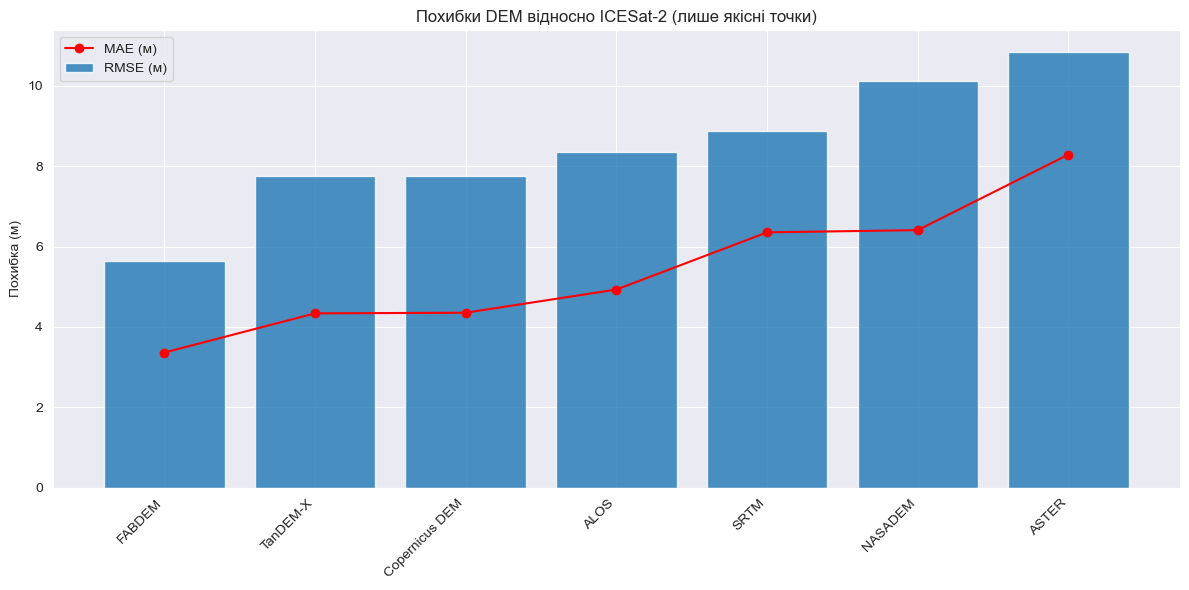

In [16]:
df_stats.sort_values(by="MAE", inplace=True)
# --- Побудова графіку ---
plt.figure(figsize=(12, 6))
plt.bar(df_stats["DEM_readable"], df_stats["RMSE"], label="RMSE (м)", alpha=0.8)
plt.plot(df_stats["DEM_readable"], df_stats["MAE"], marker="o", color="red", label="MAE (м)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Похибка (м)")
plt.title("Похибки DEM відносно ICESat-2 (лише якісні точки)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


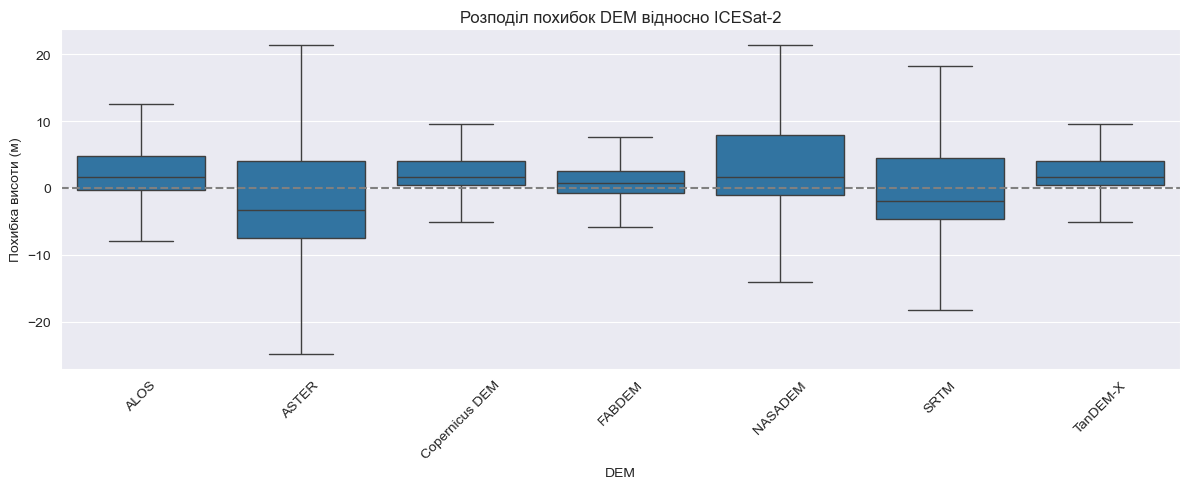

In [18]:
# Підготовка даних у long format
long_df = pd.melt(filtered,
                  id_vars=[],
                  value_vars=delta_cols,
                  var_name='DEM',
                  value_name='error')
long_df["DEM"] = long_df["DEM"].str.replace("delta_", "")
long_df["DEM"] = long_df["DEM"].map(dem_name_map).fillna(long_df["DEM"])

plt.figure(figsize=(12, 5))
sns.boxplot(data=long_df, x="DEM", y="error", showfliers=False)
plt.axhline(0, linestyle="--", color="gray")
plt.ylabel("Похибка висоти (м)")
plt.title("Розподіл похибок DEM відносно ICESat-2")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


---

##  Висновки

1. **FABDEM** показує **найменшу похибку** (MAE = 3.36 м, RMSE = 5.65 м) — найточніша DEM у цьому наборі.
2. **ASTER** має найбільшу RMSE та IQR — низька точність і велика варіабельність.
3. **NASADEM** та **Copernicus** демонструють **стійке завищення** висот (Bias > 3.5 м).
4. **SRTM** має середню якість, але занижує медіану (MedE ≈ -2.02 м).
5. **TanDEM-X** стабільна, але також завищує (Bias = +3.84 м), як і Copernicus DEM.
6. **Bias_Trend** допомагає швидко побачити систематичні помилки DEM (зсув вгору або вниз).

---



##  Файли виводу

- `df_stat.csv` — таблиця з усіма метриками
- `rmse_mae_plot.png` — графік похибок
- `dem_error_boxplot.png` — boxplot розподілу похибок

---